$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 3: Neural Network Regression

Bradley Pospeck

## Overview

Compare linear and neural network models applied to a data set of your choice.  

## Imports

In [38]:
import neuralnetworks as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Required Code

Download [nnA3.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/nnA3.tar) and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

as discussed in lecture. 

Write the following functions that train and evaluate linear and neural network models.

* `model = trainLinear(X,T,parameters)`
* `error = evaluateLinear(model,X,T)`
* `model = trainNN(X,T,parameters)`
* `error = evaluateNN(model,X,T)`

Write a new and improved version of the function we have been using to partition data into folds and combine them into training, validation and testing subsets.  Call this new version `trainValidateTestKFolds`.  Instead of returning data subsets, it applies train and evaluate functions to the subsets.  It uses the validation subset to determine the best model parameter values.  It must implement the following algorithm. The part up to "COMPLETE THIS FUNCTION..." is given in Python.  Do not change it.  Do write the rest of the function.

```
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,
                            shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []

    # COMPLETE THIS FUNCTION BY IMPLEMENTING THE FOLLOWING STEPS.
    
    # For each test fold
        for parmSet in parameterSets:  # For each set of parameter values, called parmSet
            # Find best set of parameter values
            # For each validate fold (except when same as test fold)
                # Use trainf to fit model to training data using parmSet
                # Calculate the error of this model by calling evaluatef with 
                #  the model and validation data
            # Calculate the mean of these errors.
            # If this error is less than the previously best error for parmSet, 
            # update best parameter values and best error
        # Make a new set of training data by concatenating the training and 
        # validation data from previous step.
        # Retrain, using trainf again, to fit a new model using the best set of parameter values
        #  found above, to this new training data.
        # Calculate error of this new model on the test data, and also on the new 
        #  training data.
        # Construct a list of the best parameter values with this training error, 
        #  the mean of the above valdiation errors, and the testing error. The mean of
        #  the above validation errors means the mean error over the validation folds for
        #  the best parameter values found.  So, nothing to recalculate.  Just use the mean
        #  validation set error from above that was used to pick the best parameter values.
        # Print this list if verbose == True
        # Append this list to a result list
    # Return this result list
``` 

The `parameters` argument to the `trainLinear` function is just the value of $\lambda$. For the `trainNN` function it must specify the hidden layer structure and the number of Scaled Conjugate Gradient iterations.  Here are some examples:
```
model = trainNN(X,T,[5, 100])       # Single hidden layer of 5 units, trained 
                                    # for 100 iterations
model = trainNN(X,T,[[10,10], 200]) # Two hidden layers, 10 units each, 
                                    # trained for 200 iterations
```

In [2]:
def trainLinear(X,T,parameters):
    """Standardizes the inputs, X, before calculating the means, standard deviations, 
and weights which are all returned in a dictionary. Performs ridge regression."""
    mean = np.mean(X,axis=0)
    std = np.std(X,axis=0)
    # below for loop standardizes the inputs before calculating w
    cols = X.shape[1]
    Z = np.empty(X.shape)
    for c in range(cols):
        Z[:,c] = (X[:,c]-mean[c]) / std[c]
    # Now insert column of 1's in front to account for w0
    Z1 = np.insert(Z, 0, 1, axis=1)
    w = np.linalg.lstsq(np.dot(Z1.T,Z1 + parameters),np.dot(Z1.T,T))[0]
    return {'means': mean, 'stds': std, 'w': w}

In [3]:
def evaluateLinear(model,X,T):
    """Uses the returned dictionary from trainLinear in order to calculate 
and return rmse"""
    Z = np.empty(X.shape)
    # Standardize X again
    cols = X.shape[1]
    for c in range(cols):
        Z[:,c] = (X[:,c] - model['means'][c]) / model['stds'][c]
    # insert column of 1's
    Z1 = np.insert(Z, 0, 1, axis=1)
    output = np.dot(Z1,model['w'])
    error = output - T
    sError = error **2
    msError = np.mean(sError, axis=0)
    rmse = np.sqrt(msError)
    return rmse

In [55]:
def trainNN(X,T,parameters):
    print(parameters)
    print(parameters[0])
    print(parameters[1])
    nnet = nn.NeuralNetwork(3,tuple(parameters[0]),1)
    nnet.train(X,T,nIterations=parameters[1])
    return nnet

In [46]:
def evaluateNN(model,X,T):
    out = model.use(X)
    error = out - T
    sErr = error **2
    msErr = np.mean(sErr, axis=0)
    rmse = np.sprt(msErr)
    return rmse

In [65]:
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,
                            shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []

    # COMPLETE THIS FUNCTION BY IMPLEMENTING THE FOLLOWING STEPS.
    
    for testFold in range(nFolds):
        bestErr = 1000000
        bestParm = 0
        for parmSet in parameterSets:  # For each set of parameter values, called parmSet
            valErrors = []
            # Find best set of parameter values
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Use trainf to fit model to training data using parmSet
                model = trainf(Xtrain,Ttrain,parmSet)
                # Calculate the error of this model by calling evaluatef with 
                #  the model and validation data
                valErrors.append(evaluatef(model,Xvalidate,Tvalidate))
            # Calculate the mean of these errors.
            print("valErrors={}".format(valErrors))
            meanError = sum(valErrors) / float(len(valErrors))
            # If this error is less than the previously best error for parmSet, 
            # update best parameter values and best error
            print("parmSet={}, bestErr={}, meanErr={}".format(parmSet,bestErr,meanError))
            if meanError < bestErr:
                bestErr = meanError
                bestParm = parmSet
        # Make a new set of training data by concatenating the training and 
        # validation data from previous step.
        Xtrain = np.vstack((Xtrain,Xvalidate))
        Ttrain = np.vstack((Ttrain,Tvalidate))
        # Retrain, using trainf again, to fit a new model using the best set of parameter values
        #  found above, to this new training data.
        model = trainf(Xtrain,Ttrain,bestParm)
        # Calculate error of this new model on the test data, and also on the new 
        #  training data.
        testErr = evaluatef(model,Xtest,Ttest)
        trainErr = evaluatef(model,Xtrain,Ttrain)
        # Construct a list of the best parameter values with this training error, 
        #  the mean of the above valdiation errors, and the testing error. The mean of
        #  the above validation errors means the mean error over the validation folds for
        #  the best parameter values found.  So, nothing to recalculate.  Just use the mean
        #  validation set error from above that was used to pick the best parameter values.
        result = [bestParm,trainErr,bestErr,testErr]
        # Print this list if verbose == True
        if verbose == True:
            print(result)
        # Append this list to a result list
        results.append(result)
    # Return this result list
    return results

In [27]:
X = np.arange(100).reshape((-1, 1))
T = np.abs(X -50) + X

resultant = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(0,101,10), nFolds=5, shuffle=False)
                                 
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in resultant:
    print(x)

Linear Model
  lambda        train   validate  test RMSE
[0, array([ 10.58542276]), array([ 21.69252317]), array([ 37.66891831])]
[0, array([ 15.63974738]), array([ 36.78596028]), array([ 8.61810233])]
[0, array([ 11.54479279]), array([ 22.82927776]), array([ 25.16812311])]
[0, array([ 15.58009719]), array([ 36.57051387]), array([ 9.15361565])]
[0, array([ 10.37573886]), array([ 21.12256883]), array([ 38.20804642])]


## Examples

```
X = np.arange(100).reshape((-1, 1))
T = np.abs(X -50) + X

result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(0,101,10), nFolds=5, shuffle=False)
                                 
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(*x))
```
should result in
```
Linear Model
  lambda        train   validate  test RMSE
  30.00        13.576     16.028     19.301
  100.00       22.438     20.407     20.099
  30.00        14.419     16.542     25.194
  70.00        21.098     24.589      9.615
  100.00       13.036     12.768     55.356
```

An example of fitting a neural network to this data is
```
import itertools
parms = list(itertools.product([2, 5, 10, 20, [5, 5], [10, 2, 10]], [10, 20, 100, 500]))
result = trainValidateTestKFolds(trainNN, evaluateNN, X, T, parms, nFolds=5, shuffle=False)
print('NN Model\n{:>30s} {:>10s} {:>10s} {:>10s}'.format('(Hidden Units, Iterations)', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:>30s} {:10.3f} {:10.3f} {:10.3f}'.format(str(x[0]), *x[1:]))
```
should result in something like 
```
NN Model
    (Hidden Units, Iterations)      train   validate  test RMSE
            ([10, 2, 10], 500)      0.289      1.751      0.319
                 ([5, 5], 500)      0.150      2.066      0.259
                     (20, 500)      0.045      1.174      2.584
                     (20, 500)      0.250      7.903      1.258
                     (20, 500)      0.162      2.330      5.648
```
Your results will differ, due to the initial random values for the neural network's weights.

## Data

My dataset is a [3D road network](http://archive.ics.uci.edu/ml/datasets/3D+Road+Network+%28North+Jutland%2C+Denmark%29) in Denmark.

Attribute Information:
    1. OSM_ID: OpenStreetMap ID for each road segment or edge in the graph. 
    2. Longitude: Web Mercaptor (Google format) longitude 
    3. Latitude: Web Mercaptor (Google format) latitude 
    4. Altitude: Height in meters. 
The first 3 attributes will be used to predict heights in the area with latitude and longitude. I thought it would be interesting to see how well altitude could be predicted with only 3 input attributes, especially with the 2 different methods in this assignment. 

In [26]:
data = np.genfromtxt('3D_spatial_network.txt', delimiter=',')
data.shape

(434874, 4)

In [27]:
X = data[:,0:3]

In [30]:
T = data[:,3:]

In [31]:
X,T

(array([[  1.44552912e+08,   9.34984860e+00,   5.67408757e+01],
        [  1.44552912e+08,   9.35018840e+00,   5.67406785e+01],
        [  1.44552912e+08,   9.35054850e+00,   5.67405445e+01],
        ..., 
        [  9.33232050e+07,   9.93500950e+00,   5.74992821e+01],
        [  9.33232090e+07,   9.94347870e+00,   5.74959190e+01],
        [  9.33232090e+07,   9.94345120e+00,   5.74962700e+01]]),
 array([[ 17.05277157],
        [ 17.61484024],
        [ 18.08353564],
        ..., 
        [ 19.73314057],
        [ 24.02701497],
        [ 24.63528478]]))

In [32]:
Xnames = ['OSM_ID','Longitude','Latitude']
Tname  = 'Altitude'

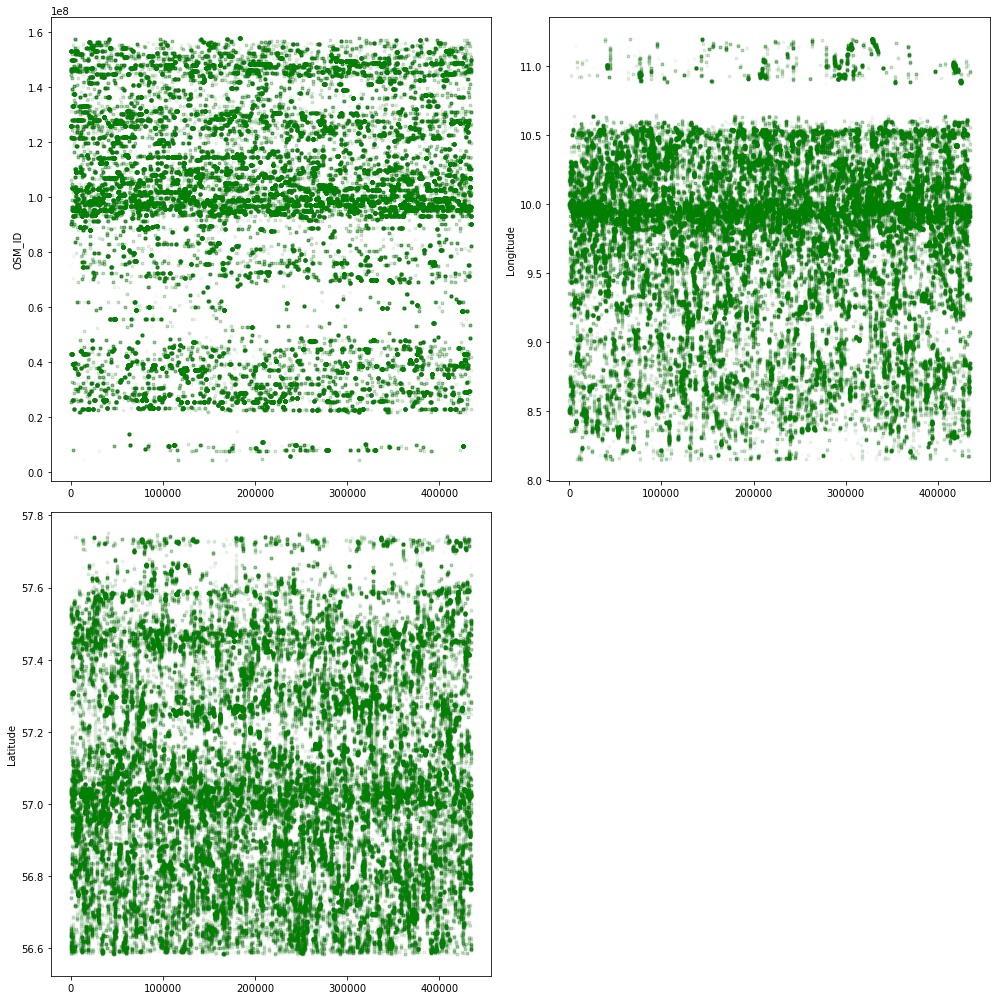

In [51]:
plt.figure(figsize=(14,14))
nrow,ncol = X.shape
for c in range(ncol):
    plt.subplot(2,2, c+1)
    plt.plot(X[:,c], 'g.',alpha=.02)
    plt.ylabel(Xnames[c])
plt.tight_layout()

There are so many data points, it's not really feasible to look at the plots of data and make observations. I don't imagine there is a bunch of linearity with this data, but I will plot all values versus the targets to see if I can notice anything.

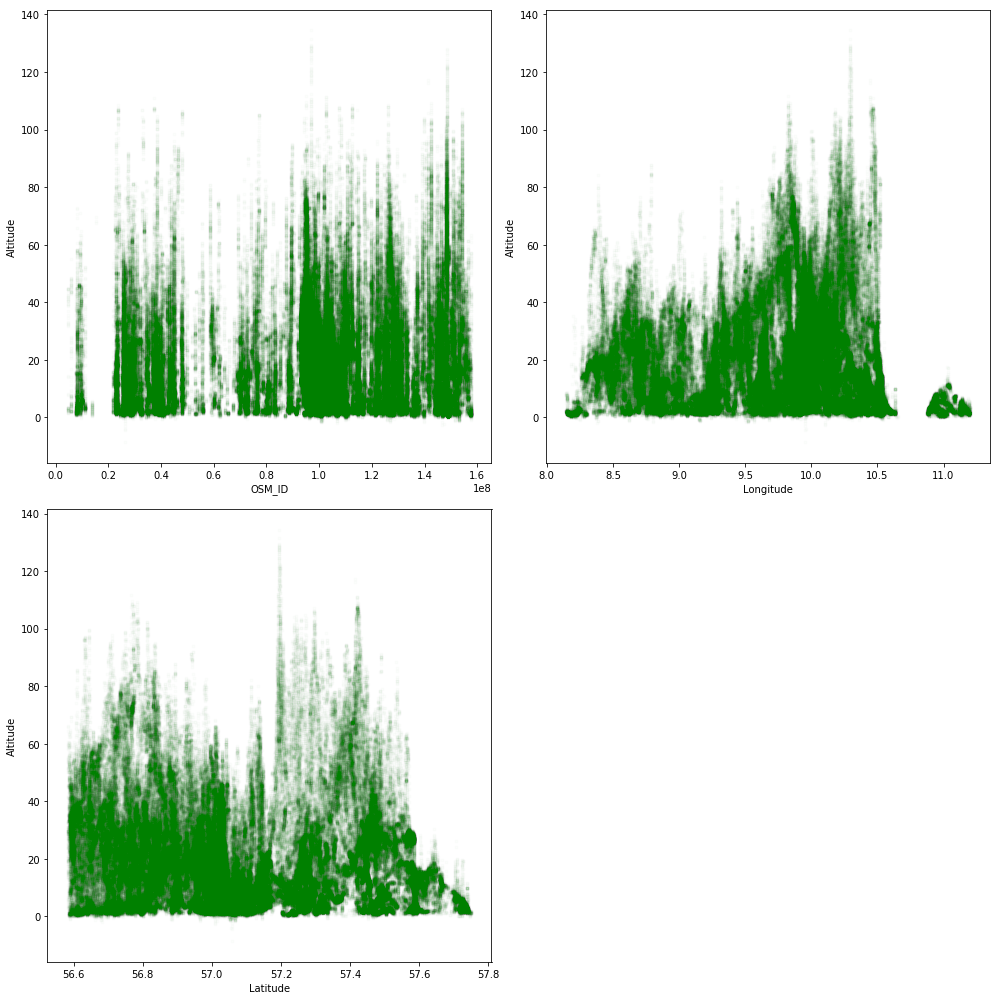

In [52]:
plt.figure(figsize=(14,14))
nrow,ncol = X.shape
for c in range(ncol):
    plt.subplot(2,2, c+1)
    plt.plot(X[:,c],T, 'g.', alpha=.01)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])
plt.tight_layout()

It looks like there may be a somewhat proportional relationship between longitude and altitude. An inversely proportional relationship looks like a possibility between latitude and altitude. The OSM_ID is much more sporadic and is probably going to be the least important attribute to consider.

## Results

Investigate the use of a linear model with various $\lambda$ values for your chosen data.  Then investigate the use of a neural network model on the same data for various sizes of hidden layers and numbers of iterations.
Discuss the results obtained, including the error values and the parameter values that result in the best performance.

Apply the `trainValidateTestKFolds` function, print the results, and discuss them.  How much variation is there in the best parameter values across different test folds?  Does the complexity of the models, in terms of the best parameters found, make sense?

## Grading

Your notebook will be run and graded automatically. Download [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect score of 80/100 if your functions are defined correctly.  The remaining 20% will be based on the instructors reading of your notebooks.  We will be looking for how well the method is explained in text with some LaTeX math, and how well the results are summarized.

In [66]:
%run -i "A3grader.py"

valErrors=[array([ 7.05336712]), array([ 3.72800064]), array([ 1.82696439]), array([ 5.64902316])]
parmSet=0, bestErr=1000000, meanErr=[ 4.56433883]
valErrors=[array([ 28.34118038]), array([ 17.74468331]), array([ 18.2293616]), array([ 19.6541877])]
parmSet=10, bestErr=[ 4.56433883], meanErr=[ 20.99235325]
valErrors=[array([ 29.36279057]), array([ 18.76014062]), array([ 19.17465155]), array([ 20.32460858])]
parmSet=20, bestErr=[ 4.56433883], meanErr=[ 21.90554783]
valErrors=[array([ 29.72533792]), array([ 19.12049362]), array([ 19.51009589]), array([ 20.56252078])]
parmSet=30, bestErr=[ 4.56433883], meanErr=[ 22.22961205]
valErrors=[array([ 29.91104068]), array([ 19.30507017]), array([ 19.68191239]), array([ 20.68438229])]
parmSet=40, bestErr=[ 4.56433883], meanErr=[ 22.39560138]
valErrors=[array([ 30.02392136]), array([ 19.41726551]), array([ 19.78635101]), array([ 20.75845627])]
parmSet=50, bestErr=[ 4.56433883], meanErr=[ 22.49649854]
valErrors=[array([ 30.09979303]), array([ 19.492

ValueError: shapes (10,1) and (3,5) not aligned: 1 (dim 1) != 3 (dim 0)